# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import pandas as pd
import geopandas as gpd

import sys
sys.path.append("../src")

import usa_data_Tij as USA_data
import indices
from parameters import params_default
#del sys.modules['dynamics']
from dynamics import Dynamics

In [3]:
import importlib
#importlib.reload(USdata)

In [4]:
#T0_total, counties_pop, counties_in_state, states_in_division = USA_data.compute_Tij_from_data()

In [5]:
(census, counties_census, states_census, commuting, counties_FIPS, states_FIPS, divisions_FIPS, countyFIPS_to_index,
statesFIPS_to_index, divisionsFIPS_to_index, index_to_countyFIPS, index_to_statesFIPS, index_to_divisionsFIPS,
USstates, USdivisions, counties_pop, states_pop, divisions_pop, counties_in_state, states_in_division,
n_counties, commuting_matrix, citytocounty, faatravel, airport_enplane, Ftravelers_matrix, mod_airport_enplane,
mod_airport_arrivals, mobility_matrix, counties_realpop, frac_mobilers, frac_pop, T0_total) = USA_data.compute_Tij_from_data(output='all')

In [6]:
N, Ntots = indices.set_N_arrays (counties_pop, counties_in_state, states_in_division)
ichild = indices.set_ichild_arrays(N, Ntots, counties_in_state, states_in_division)
iparent = indices.set_iparent_arrays (N, Ntots, ichild)

# Importing Maps

In [7]:
folder_geodata = '../data/geodata'

## Counties

In [8]:
gdf_counties = gpd.read_file('%s/US_counties_geo/cb_2021_us_county_500k.shp'%(folder_geodata))

# Remove states like Virgin Islands and Puerto Rico
gdf_counties = gdf_counties[gdf_counties["STATEFP"].isin(USstates['FIPS'])]

gdf_counties['FIPS'] = gdf_counties['STATEFP']+gdf_counties['COUNTYFP']

# Check which counties from geofile are not in the counties_FIPS list we're using
print(gdf_counties[ ~gdf_counties['FIPS'].isin(counties_FIPS) ])

# Check which counties in our counties_FIPS list are not in geofile
UScounties_FIPS = counties_census.loc[:,'STATE'] + counties_census.loc[:,'COUNTY']
print(counties_census[ ~UScounties_FIPS.isin(gdf_counties['FIPS'])  ])

# Order gdf_counties in the same order as population arrays
ref = UScounties_FIPS.to_numpy()
test = gdf_counties['FIPS'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_counties = gdf_counties.iloc[ordering,:]

# Define a simplified map without Hawaii and Alaska
gdf_counties_simple = gdf_counties[~gdf_counties["STATEFP"].isin(['02','15'])]

# Order gdf_counties_simple in the same order as population arrays
ref = UScounties_FIPS[~counties_census['STATE'].isin(['02','15'])].to_numpy()
test = gdf_counties_simple['FIPS'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_counties_simple = gdf_counties_simple.iloc[ordering,:]

Empty GeoDataFrame
Columns: [STATEFP, COUNTYFP, COUNTYNS, AFFGEOID, GEOID, NAME, NAMELSAD, STUSPS, STATE_NAME, LSAD, ALAND, AWATER, geometry, FIPS]
Index: []
Empty DataFrame
Columns: [REGION, DIVISION, STATE, COUNTY, STNAME, CTYNAME, POPULATION, FIPS]
Index: []


## States

In [9]:
gdf_states = gpd.read_file('%s/US_states_geo/cb_2022_us_state_500k.shp'%(folder_geodata))

# Remove: American Samoa, Puerto Rico, United States Virgin Islands,
#         Guam, and Commonwealth of the Northern Mariana Islands
gdf_states = gdf_states[gdf_states['STATEFP'].isin(USstates['FIPS'])]
#gdf_states = gdf_states[~gdf_states["STATEFP"].isin(['60','72','78','66','69'])]

# Check which states from geofile are not in the states_FIPS list we're using
print(gdf_states[ ~gdf_states['STATEFP'].isin(states_FIPS) ])

# Check which states in our states_FIPS list are not in geofile
USstates_FIPS = states_census.loc[:,'STATE']
print(states_census[ ~USstates_FIPS.isin(gdf_states['STATEFP'])  ])

# Order gdf in the same order as population arrays
ref = USstates_FIPS.to_numpy()
test = gdf_states['STATEFP'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_states = gdf_states.iloc[ordering,:]

# Define a simplified map without Hawaii and Alaska
gdf_states_simple = gdf_states[~gdf_states['STATEFP'].isin(['02','15'])]
gdf_states_simple_wAK = gdf_states[~gdf_states['STATEFP'].isin(['15'])]

# Order gdf_states_simple in the same order as population arrays
ref = USstates_FIPS[~states_census['STATE'].isin(['02','15'])].to_numpy()
test = gdf_states_simple['STATEFP'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_states_simple = gdf_states_simple.iloc[ordering,:]

Empty GeoDataFrame
Columns: [STATEFP, STATENS, AFFGEOID, GEOID, STUSPS, NAME, LSAD, ALAND, AWATER, geometry]
Index: []
Empty DataFrame
Columns: [REGION, DIVISION, STATE, COUNTY, STNAME, CTYNAME, POPULATION, FIPS]
Index: []


## Divisions

In [10]:
gdf_divisions = gpd.read_file('%s/US_divisions_geo/cb_2022_us_division_500k.shp'%(folder_geodata))

# FIPS of divisions
USdivisions_FIPS = divisions_FIPS

# Order gdf_divisions in the same order as division arrays
ref = USdivisions_FIPS
test = gdf_divisions['DIVISIONCE'].to_numpy()
ordering = [ np.argwhere(ref[ii]==test)[0,0] for ii in range(len(ref)) ]
gdf_divisions = gdf_divisions.iloc[ordering,:]

# Create dataframe of division of states without Alaska and Hawaii
division_of_states = states_census['DIVISION']
division_of_states_simple = division_of_states[~states_census['STATE'].isin(['02','15'])]

# Add division to states geodata
gdf_states_simple['DIVISION'] = division_of_states_simple.to_numpy()

# Merge states of same division
gdf_divisions_simple = gdf_divisions.copy()

for ii in range(len(USdivisions_FIPS)):
    
    states_in_division_ii = (gdf_states_simple['DIVISION'] == USdivisions_FIPS[ii])
    poly_division_ii = gdf_states_simple[states_in_division_ii]['geometry'].unary_union
    
    position_ii = (gdf_divisions_simple['DIVISIONCE'] == USdivisions_FIPS[ii])
    gdf_divisions_simple['geometry'][position_ii] = poly_division_ii


#gdf_divisions_simple.plot()

## Countries and World

In [11]:
gdf_world = gpd.read_file('%s/World_countries_geo/ne_10m_admin_0_countries.shp'%(folder_geodata))
#gdf_mexico_states = gpd.read_file('%s/MX_states_geo/mex_admbnda_adm1_govmex_20210618.shp'%(folder_geodata))
#gdf_canada_states = gpd.read_file('%s/Canada_states_geo/lpr_000b16a_e.shp'%(folder_geodata))

gdf_world = gdf_world.to_crs('EPSG:4269')
#gdf_mexico_states = gdf_mexico_states.to_crs('EPSG:4269')
#gdf_canada_states = gdf_canada_states.to_crs('EPSG:4269')

#gdf_world_continents = gpd.read_file('%s/World_continents_geo/World_Continents.shp'%(folder_geodata))

## Less accuracy maps

In [12]:
# To decrease size of images generated

#gdf_canada_states_lessacc = gdf_canada_states.copy()
#gdf_canada_states_lessacc['geometry'] = gdf_canada_states['geometry'].simplify(tolerance=0.1)

#gdf_mexico_states_lessacc = gdf_mexico_states.copy()
#gdf_mexico_states_lessacc['geometry'] = gdf_mexico_states['geometry'].simplify(tolerance=0.1)

gdf_states_simple_lessacc = gdf_states_simple.copy()
gdf_states_simple_lessacc['geometry'] = gdf_states_simple['geometry'].simplify(tolerance=0.1)

gdf_counties_simple_lessacc = gdf_counties_simple.copy()
gdf_counties_simple_lessacc['geometry'] = gdf_counties_simple['geometry'].simplify(tolerance=0.1)

gdf_world_lessacc = gdf_world.copy()
gdf_world_lessacc['geometry'] = gdf_world['geometry'].simplify(tolerance=0.1)

#gdf_world_continents_lessacc = gdf_world_continents.copy()
#gdf_world_continents_lessacc['geometry'] = gdf_world_continents['geometry'].simplify(tolerance=0.1)

# Plots

In [15]:
outputfolder='../plots/fig2_Rij'

## Plot (3,x): USA

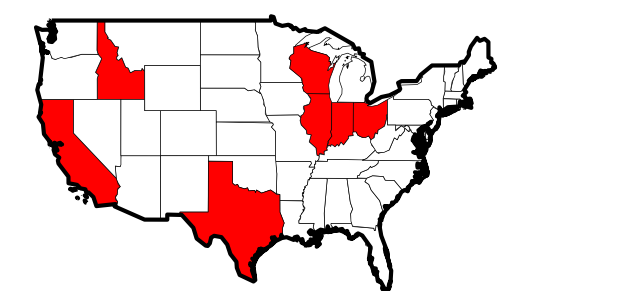

In [16]:
export_file = True
filename = 'usa_3-2'
append = ''

figsize = [8,6]
fig, ax = plt.subplots(1, 1, figsize=figsize)

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_axis_off()
ax.set_xlim(left=-128,right=-50)
ax.set_ylim(bottom=25,top=50)

# Set US to red
policy_states = np.zeros(len(gdf_states_simple_lessacc), dtype=int)
red_US_states = ['California', 'Texas', 'Idaho', 'Wisconsin', 'Illinois', 'Indiana', 'Ohio']
red_index =  np.where( (gdf_states_simple['NAME'].isin(red_US_states)).to_numpy() )
policy_states[red_index] = 1

# Plot states
gdf_states_simple_lessacc.plot(policy_states, ax=ax, cmap=cmap, edgecolor='k', linewidth=0.5)

# Plot country
select_usa = (gdf_world['SOVEREIGNT']=='United States of America') & (gdf_world['TYPE']=='Country')

gdf_world_lessacc[select_usa].plot( ax=ax, cmap=cmap, facecolor='none', edgecolor='k', linewidth=3 )

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()

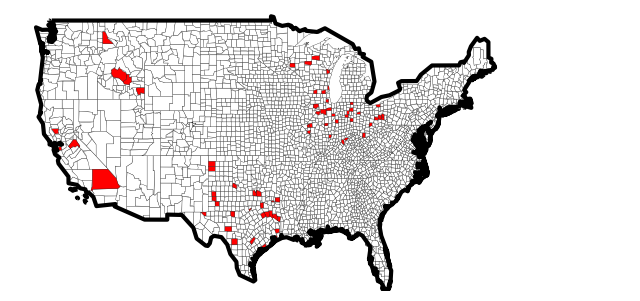

In [28]:
export_file = True
filename = 'usa_3-1'
append = ''

figsize = [8,6]
fig, ax = plt.subplots(1, 1, figsize=figsize)

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_axis_off()
ax.set_xlim(left=-128,right=-50)
ax.set_ylim(bottom=25,top=50)

gen = np.random.default_rng(232323)

# Choose red counties randomly from some states
policy_counties = np.zeros(len(gdf_counties_simple_lessacc), dtype=int)
red_US_states = ['California', 'Texas', 'Idaho', 'Wisconsin', 'Illinois', 'Indiana', 'Ohio']

gdf_red_states = [ gdf_counties_simple[gdf_counties_simple['STATE_NAME']==state].copy() for state in red_US_states ]
indices_red_counties = [ gdfs.iloc[gen.choice(np.arange(len(gdfs)), size=int(len(gdfs)/10), replace=False)].index.to_numpy() for gdfs in gdf_red_states ]
indices_red_counties = np.concatenate(indices_red_counties)

position_red_counties = np.array( [gdf_counties_simple.index.get_loc(ii) for ii in indices_red_counties ])
policy_counties[position_red_counties] = 1

#print(gdf_simple.loc[indices_red_states]['NAME'])
#print(gdf_simple.iloc[test]['NAME'])

# Plot counties
gdf_counties_simple_lessacc.plot(policy_counties, ax=ax, cmap=cmap, edgecolor='k', linewidth=0.2)

# Plot country
select_usa = (gdf_world['SOVEREIGNT']=='United States of America') & (gdf_world['TYPE']=='Country')

gdf_world_lessacc[select_usa].plot( ax=ax, cmap=cmap, facecolor='none', edgecolor='k', linewidth=3 )

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()

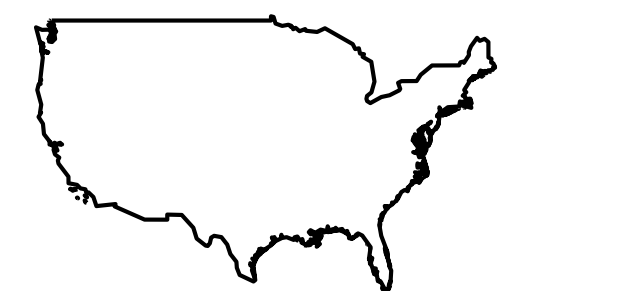

In [18]:
export_file = True
filename = 'usa_3-0'
append = ''

figsize = [8,6]
fig, ax = plt.subplots(1, 1, figsize=figsize)

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

ax.set_axis_off()
ax.set_xlim(left=-128,right=-50)
ax.set_ylim(bottom=25,top=50)

# Plot country
select_usa = (gdf_world['SOVEREIGNT']=='United States of America') & (gdf_world['TYPE']=='Country')

gdf_world_lessacc[select_usa].plot( ax=ax, cmap=cmap, facecolor='none', edgecolor='k', linewidth=3 )

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()

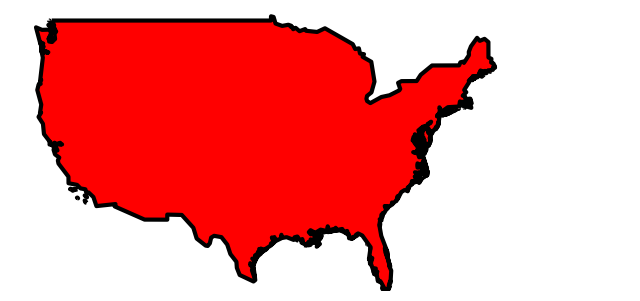

In [19]:
export_file = True
filename = 'usa_3-3'
append = ''

figsize = [8,6]
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax.set_axis_off()
ax.set_xlim(left=-128,right=-50)
ax.set_ylim(bottom=25,top=50)

# Plot country
select_usa = (gdf_world['SOVEREIGNT']=='United States of America') & (gdf_world['TYPE']=='Country')

gdf_world_lessacc[select_usa].plot( ax=ax, facecolor='red', edgecolor='k', linewidth=3 )

if export_file:
    plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

plt.show()

## Plot (2,x): States

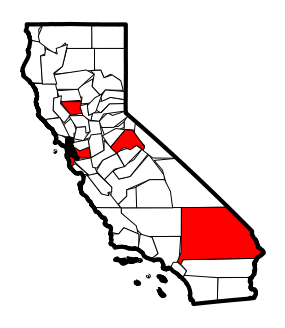

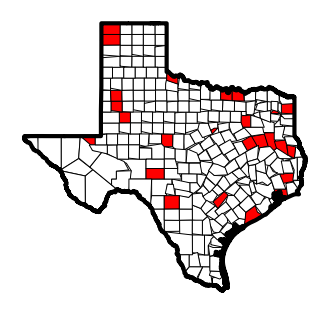

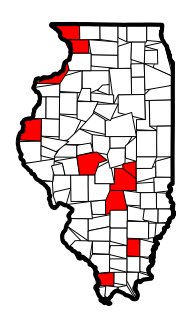

In [20]:
export_file = True
filename = 'states_2-1'

color0 = 'white'
color1 = 'red'

cmap = colors.ListedColormap([color0, color1])
bounds = [-0.5, 0.5, 1.5]  # Specify the boundaries for the colorbar ticks
norm = colors.BoundaryNorm(bounds, cmap.N)

gen = np.random.default_rng(232323)

states_toplot = ['California', 'Texas', 'Illinois']
n_states = len(states_toplot)

for state in states_toplot:
    
    figsize = [4,4]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_axis_off()
    
    append = f'_{state}'
    
    gdf_state_plot = gdf_states_simple[ gdf_states_simple['NAME']==state ].copy()
    gdf_counties_instate = gdf_counties_simple_lessacc[gdf_counties_simple_lessacc['STATE_NAME']==state].copy()
    
    # Choose red counties randomly
    policy_counties = np.zeros( len(gdf_counties_instate), dtype=int)
    
    position_red_counties = gen.choice(np.arange(len(policy_counties)), size=int(len(policy_counties)/10), replace=False)
    policy_counties[position_red_counties] = 1
    
    # Plot counties
    gdf_counties_instate.plot(policy_counties, ax=ax, cmap=cmap, edgecolor='k', linewidth=0.7)

    # Plot states
    gdf_state_plot.plot(ax=ax, cmap=cmap, facecolor='none', edgecolor='k', linewidth=3)

    if export_file:
        plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

    plt.show()

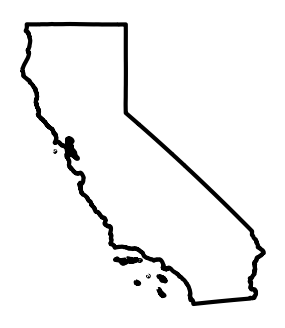

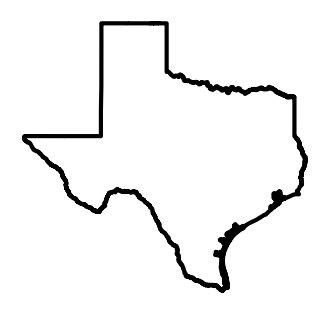

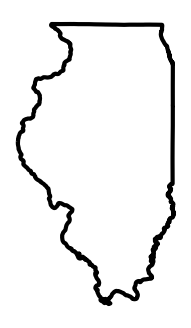

In [21]:
export_file = True
filename = 'states_2-0'

states_toplot = ['California', 'Texas', 'Illinois']

for state in states_toplot:
    
    figsize = [4,4]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_axis_off()
    
    append = f'_{state}'
    
    gdf_state_plot = gdf_states_simple[ gdf_states_simple['NAME']==state ].copy()

    # Plot states
    gdf_state_plot.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=3)

    if export_file:
        plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

    plt.show()

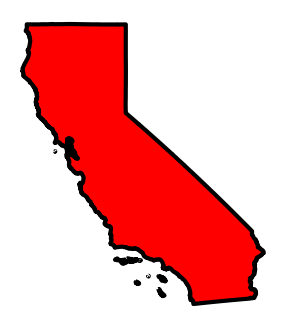

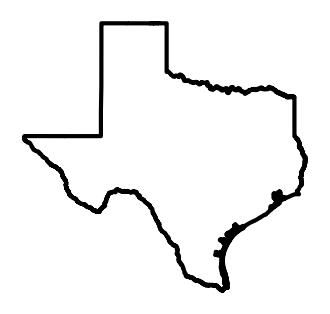

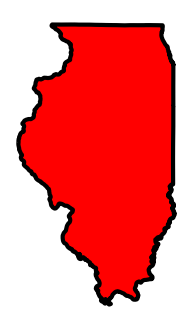

In [22]:
export_file = True
filename = 'states_2-2'

states_toplot = ['California', 'Texas', 'Illinois']
color = ['red', 'white', 'red']

for state in states_toplot:
    
    figsize = [4,4]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_axis_off()
    
    append = f'_{state}'
    
    gdf_state_plot = gdf_states_simple[ gdf_states_simple['NAME']==state ].copy()

    # Plot states
    gdf_state_plot.plot(ax=ax, facecolor=color[states_toplot.index(state)], edgecolor='k', linewidth=3)

    if export_file:
        plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

    plt.show()

## Plot (1,x): Counties

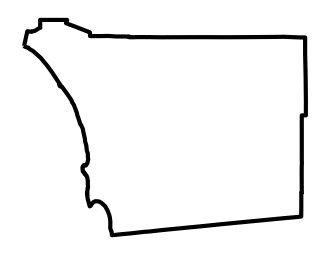

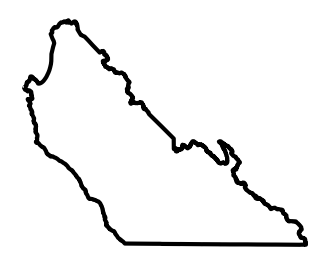

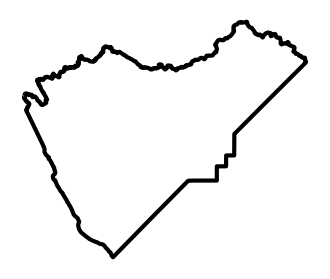

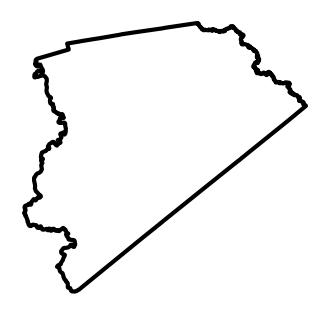

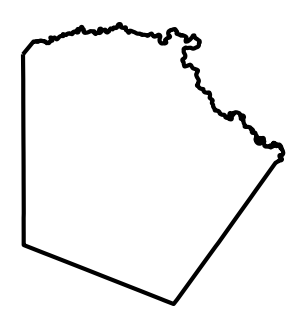

In [26]:
export_file = True
filename = 'counties_1-0'

counties_toplot = ['San Diego', 'Monterey', 'Mariposa', 'Houston', 'Bexar']
state_of = ['California','California','California','Texas','Texas']

for county in counties_toplot:
    
    figsize = [4,4]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_axis_off()
    
    append = f'_{county}'
    
    gdf_county_plot = gdf_counties_simple[ (gdf_counties_simple['NAME']==county) & (gdf_counties_simple['STATE_NAME']==state_of[counties_toplot.index(county)]) ].copy()

    # Plot states
    gdf_county_plot.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=3)

    if export_file:
        plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

    plt.show()

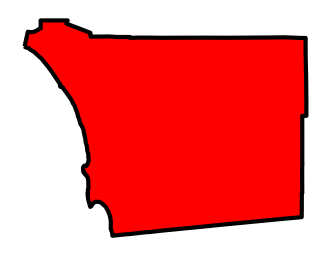

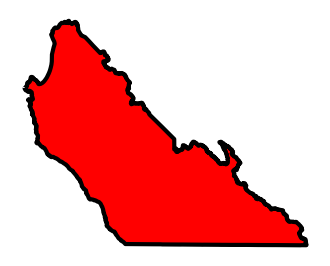

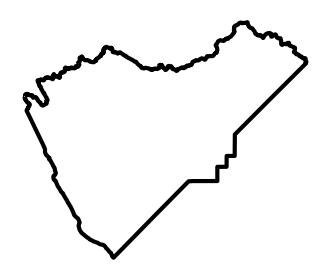

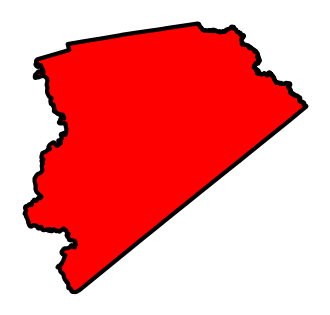

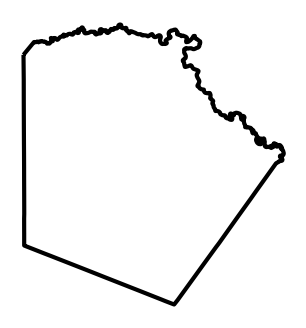

In [25]:
export_file = True
filename = 'counties_1-1'

counties_toplot = ['San Diego', 'Monterey', 'Mariposa', 'Houston', 'Bexar']
state_of = ['California','California','California','Texas','Texas']
color = ['red', 'red', 'white', 'red', 'white']

for county in counties_toplot:
    
    figsize = [4,4]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_axis_off()
    
    append = f'_{county}'
    
    gdf_county_plot = gdf_counties_simple[ (gdf_counties_simple['NAME']==county) & (gdf_counties_simple['STATE_NAME']==state_of[counties_toplot.index(county)]) ].copy()

    # Plot states
    gdf_county_plot.plot(ax=ax, facecolor=color[counties_toplot.index(county)], edgecolor='k', linewidth=3)

    if export_file:
        plt.savefig(fname=f'{outputfolder}/{filename}{append}.pdf', dpi=200)

    plt.show()